In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from copy import deepcopy
import sys
sys.path.append('../functions')
from IVfunctions import * 
from PreproFunctions import * 

# Approach 2: Top Down (Average/Sum Team Stats and attach to the Match Data) 

## Load in and Prepare the Player Data

In [2]:
#Load in the player data
df_players = pd.read_csv('../data/PlayerData_v1.csv',index_col=0)

## Load in and Prepare the Match Data

In [3]:
#Load in the match data
df_matches = pd.read_csv('../data/MatchData_v2.csv',index_col=0)

In [4]:
df_matches.columns.to_list()

['Team',
 'Opponent',
 'PointsF',
 'PointsA',
 'Venue',
 'Season',
 'Round',
 'Day',
 'Date',
 'Attendance',
 'Outcome',
 'H/A',
 'oppH/A',
 'City',
 'Rain (mm)',
 'Max Temp (C)',
 'Min Temp (C)',
 'Max Humid (%)',
 'Min Humid (%)',
 'Wind Speed (m/s)',
 'Solar Rad (MJ/sq m)']

In [5]:
df_finalists=df_matches[df_matches['Round'].str.contains(r'Final')][['Season','Team']].drop_duplicates()
df_finalists['prevSeasFinl'] = 1
df_finalists['Season_Join'] = df_finalists['Season']+1
df_finalists.drop('Season',axis=1,inplace=True)

In [6]:
df_matches_v3 = top_down_preproc(df_players,df_matches,2024) #Remove 2024 data

### Final Analysis Version Data: 

In [7]:
#Join on the season_win_rate and win_streak for the opponent
df_matches_v3 = df_matches_v3.merge(df_matches_v3[['Opponent','Season','Round','season_win_rate','win_streak']],\
                    left_on=['Team','Season','Round'],right_on=['Opponent','Season','Round'],suffixes=('_team','_opp'))

#Remove Opponent_opp and rename Opponent_team
df_matches_v3 = df_matches_v3.drop('Opponent_opp',axis=1)
df_matches_v3.rename(columns={'Opponent_team':'Opponent'}, inplace=True)

In [8]:
#Rebin the win streak
def bin_winstreak(x):
    if x >= 0  and x <= 2:
        return 'a. [0,2]'
    else:
        return 'b. (2,Inf)'
     
df_matches_v3['win_streak_team_binned'] = df_matches_v3['win_streak_team'].apply(bin_winstreak) 
df_matches_v3['win_streak_opp_binned'] = df_matches_v3['win_streak_opp'].apply(bin_winstreak) 

In [9]:
#Encode and split data (statsmodels version)
df_ML_IT_sm,df_ML_OOT_sm,X_train_sm,y_train_sm,X_test_sm,y_test_sm = encode_split_data(df_matches_v3,OOT_year=2022,encode=False) 

In [10]:
#Encode and split data (other)
df_ML_IT,df_ML_OOT,X_train,y_train,X_test,y_test = encode_split_data(df_matches_v3,OOT_year=2022,encode=True) 

# Logistic Regression

## Information Values

In [11]:
#Prepare data for IV by binning with 10% deciles
X_train_sm_IV = decile_binning(X_train_sm)
df_IV,Xout = IV_summary(pd.concat([X_train_sm_IV,y_train_sm],axis=1),'Outcome')

<Axes: xlabel='Variable'>

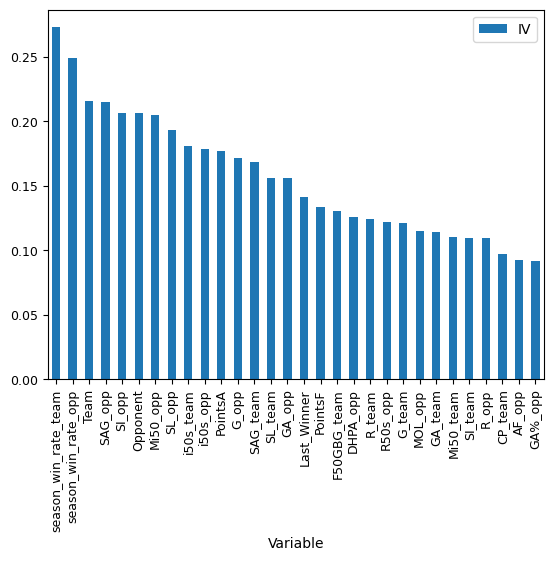

In [12]:
df_IV.head(30).plot.bar(x = 'Variable', y = 'IV', fontsize='9')

In [13]:
#Get columns based on information value
feature_cols = df_IV.head(30).Variable.to_list()
num_cols = deepcopy(feature_cols)
num_cols.remove('Team')
num_cols.remove('Opponent')

## Check for High Correlations

In [14]:
corr = X_train_sm[num_cols].corr()

corr.style.background_gradient(cmap='coolwarm')

,season_win_rate_team,season_win_rate_opp,SAG_opp,SI_opp,Mi50_opp,SL_opp,i50s_team,i50s_opp,PointsA,G_opp,SAG_team,SL_team,GA_opp,Last_Winner,PointsF,F50GBG_team,DHPA_opp,R_team,R50s_opp,G_team,MOL_opp,GA_team,Mi50_team,SI_team,R_opp,CP_team,AF_opp,GA%_opp
season_win_rate_team,1.000000,0.064064,-0.589328,-0.539392,-0.539230,-0.584516,0.495338,-0.489424,-0.606446,-0.596722,0.542290,0.541904,-0.545647,0.273285,0.543388,0.431669,0.413847,0.472831,0.311974,0.537758,-0.339445,0.483231,0.431188,0.448416,-0.426668,0.310106,-0.335855,-0.463415
season_win_rate_opp,0.064064,1.000000,-0.054494,-0.035292,-0.037274,-0.054470,0.044186,-0.049297,-0.050866,-0.048723,0.056201,0.060541,-0.026811,-0.254904,0.051872,0.023937,0.024095,0.041921,0.028241,0.049950,-0.010691,0.044563,0.054019,0.053061,-0.045237,-0.018747,-0.045195,-0.026371
SAG_opp,-0.589328,-0.054494,1.000000,0.904963,0.781345,0.957624,-0.219081,0.806349,0.899682,0.860671,-0.160450,-0.159798,0.796577,-0.184528,-0.159507,-0.257037,-0.278720,-0.082851,-0.257926,-0.161053,0.496457,-0.158653,-0.243004,-0.098781,0.792784,-0.011123,0.667937,0.611827
SI_opp,-0.539392,-0.035292,0.904963,1.000000,0.806373,0.921659,-0.169878,0.722839,0.896851,0.864206,-0.105568,-0.092124,0.843396,-0.163200,-0.079636,-0.233245,-0.263997,-0.025400,-0.275541,-0.081787,0.475578,-0.080313,-0.165004,-0.016243,0.794989,-0.035216,0.719168,0.651723
Mi50_opp,-0.539230,-0.037274,0.781345,0.806373,1.000000,0.772429,-0.249765,0.630372,0.791558,0.773710,-0.222471,-0.212822,0.792888,-0.183448,-0.181138,-0.296824,-0.301366,-0.165032,-0.257386,-0.179316,0.446786,-0.172370,-0.235757,-0.129928,0.637977,-0.160763,0.593782,0.555560
SL_opp,-0.584516,-0.054470,0.957624,0.921659,0.772429,1.000000,-0.225725,0.792044,0.918634,0.875849,-0.157156,-0.132346,0.815934,-0.176408,-0.139107,-0.248050,-0.288739,-0.052427,-0.293131,-0.139634,0.504346,-0.140268,-0.232384,-0.083647,0.820199,-0.032194,0.648293,0.645251
i50s_team,0.495338,0.044186,-0.219081,-0.169878,-0.249765,-0.225725,1.000000,-0.181974,-0.200307,-0.187416,0.809957,0.793522,-0.171006,0.152130,0.735092,0.658704,0.697798,0.782506,0.777333,0.685702,-0.134606,0.658591,0.618161,0.726671,0.039516,0.676463,0.093391,-0.116119
i50s_opp,-0.489424,-0.049297,0.806349,0.722839,0.630372,0.792044,-0.181974,1.000000,0.731500,0.689324,-0.168612,-0.171417,0.640376,-0.152234,-0.147906,-0.206555,-0.272366,-0.011265,-0.202052,-0.145496,0.446907,-0.157147,-0.243911,-0.129982,0.735926,0.150870,0.672694,0.480297
PointsA,-0.606446,-0.050866,0.899682,0.896851,0.791558,0.918634,-0.200307,0.731500,1.000000,0.992886,-0.160703,-0.146720,0.924140,-0.187321,-0.115887,-0.272573,-0.303927,-0.091319,-0.279160,-0.118373,0.458582,-0.117518,-0.205018,-0.069378,0.818899,-0.037534,0.659582,0.808015
G_opp,-0.596722,-0.048723,0.860671,0.864206,0.773710,0.875849,-0.187416,0.689324,0.992886,1.000000,-0.157203,-0.142893,0.928577,-0.186454,-0.114068,-0.262324,-0.283107,-0.090208,-0.260220,-0.117741,0.432164,-0.114242,-0.196716,-0.066415,0.808714,-0.038813,0.640193,0.831540


In [15]:
with pd.option_context('display.max_row',None):
    print(df_IV)

                   Variable        IV
106    season_win_rate_team  0.272809
117     season_win_rate_opp  0.249301
119                    Team  0.215730
54                  SAG_opp  0.215135
96                   SI_opp  0.206769
120                Opponent  0.206509
84                 Mi50_opp  0.204677
55                   SL_opp  0.192867
20                i50s_team  0.181035
68                 i50s_opp  0.178599
104                 PointsA  0.176916
56                    G_opp  0.171660
6                  SAG_team  0.168174
7                   SL_team  0.156074
94                   GA_opp  0.155884
105             Last_Winner  0.141630
103                 PointsF  0.133499
45              F50GBG_team  0.130739
61                 DHPA_opp  0.126155
33                   R_team  0.124405
71                 R50s_opp  0.121962
8                    G_team  0.121472
86                  MOL_opp  0.114804
46                  GA_team  0.114125
36                Mi50_team  0.110248
48          

In [16]:
def bucket_day(x):
    if x in ['Mon','Wed']:
        return 'Mon_Wed'
    else:
        return 'OTHER'
    
def bucket_venue(x):
    if x in ['Jiangwan Stadium','Riverway Stadium','Stadium Australia']:
        return 'Jiangwan_or_Riverway_or_StadAus'
    else:
        return 'OTHER'
    
    
X_train_sm['Day_binned'] = X_train_sm['Day'].apply(bucket_day)
X_test_sm['Day_binned'] = X_test_sm['Day'].apply(bucket_day)
df_ML_OOT_sm['Day_binned'] = df_ML_OOT_sm['Day'].apply(bucket_day)

X_train_sm['Venue_binned'] = X_train_sm['Venue'].apply(bucket_venue)
X_test_sm['Venue_binned'] = X_test_sm['Venue'].apply(bucket_venue)
df_ML_OOT_sm['Venue_binned'] = df_ML_OOT_sm['Venue'].apply(bucket_venue)

X_train_sm['DE_perc_opp'] = X_train_sm['DE%_opp']
X_test_sm['DE_perc_opp'] = X_test_sm['DE%_opp']
df_ML_OOT_sm['DE_perc_opp'] = df_ML_OOT_sm['DE%_opp']


In [17]:
import statsmodels.formula.api as smf
log_reg = smf.logit("Outcome ~ G_opp + season_win_rate_team + season_win_rate_opp + HA + oppHA+\
prevSeasFinl_team+prevSeasFinl_opp", data=pd.concat([X_train_sm,y_train_sm],axis=1)).fit()

Optimization terminated successfully.
         Current function value: 0.610109
         Iterations 5


In [18]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                 1978
Model:                          Logit   Df Residuals:                     1970
Method:                           MLE   Df Model:                            7
Date:                Sun, 21 Apr 2024   Pseudo R-squ.:                  0.1198
Time:                        14:19:23   Log-Likelihood:                -1206.8
converged:                       True   LL-Null:                       -1371.0
Covariance Type:            nonrobust   LLR p-value:                 4.912e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.9263      0.408      2.270      0.023       0.127       1.726
HA[T.H]                  0.4722      0.115      4.102      0.000       0.247       0.698
oppHA[T.H]  

## Variance Inflation Factor

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
vif_data = pd.DataFrame()
X = X_train_sm[['G_opp','season_win_rate_team','season_win_rate_opp','prevSeasFinl_team','prevSeasFinl_opp']]
X_cats = pd.get_dummies(X_train_sm[['HA','oppHA']],drop_first=True).astype(int)
X = pd.concat([X,X_cats],axis=1)

vif_data["feature"] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values,i) for i in range(len(X.columns))]

In [20]:
vif_data

,feature,VIF
0,G_opp,8.900522
1,season_win_rate_team,5.873657
2,season_win_rate_opp,7.456864
3,prevSeasFinl_team,2.177955
4,prevSeasFinl_opp,2.235864
5,HA_H,2.954305
6,oppHA_H,2.884236


### Correlations

In [21]:
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm')

,G_opp,season_win_rate_team,season_win_rate_opp,prevSeasFinl_team,prevSeasFinl_opp,HA_H,oppHA_H
G_opp,1.000000,-0.596722,-0.048723,-0.295843,-0.045682,0.119797,0.077739
season_win_rate_team,-0.596722,1.000000,0.064064,0.398103,0.039392,-0.053667,0.001537
season_win_rate_opp,-0.048723,0.064064,1.000000,0.044320,0.420965,0.026303,-0.072396
prevSeasFinl_team,-0.295843,0.398103,0.044320,1.000000,-0.005845,-0.020475,0.016192
prevSeasFinl_opp,-0.045682,0.039392,0.420965,-0.005845,1.000000,0.027868,-0.043082
HA_H,0.119797,-0.053667,0.026303,-0.020475,0.027868,1.000000,-0.504300
oppHA_H,0.077739,0.001537,-0.072396,0.016192,-0.043082,-0.504300,1.000000


### Training Data

In [22]:
y_train_pred = log_reg.predict(X_train_sm) 

from sklearn.metrics import roc_curve,roc_auc_score
fpr,tpr, thresholds = roc_curve(y_train_sm,y_train_pred)

Text(0.5, 1.0, 'Training ROC Curve')

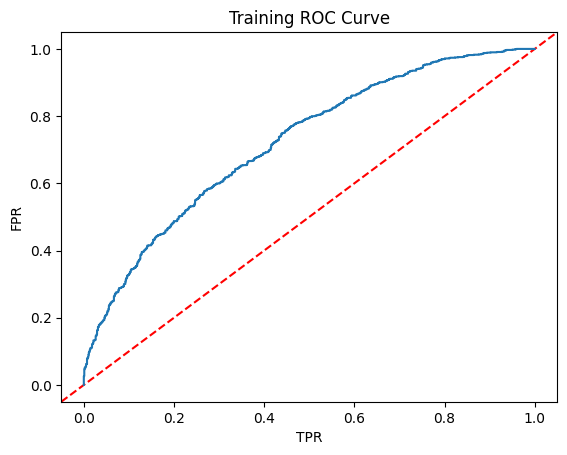

In [23]:
fig,ax = plt.subplots()

ax.axline((0,0),slope=1,color='red',linestyle='--')
ax.plot(fpr,tpr)
ax.set_xlabel('TPR')
ax.set_ylabel('FPR')
ax.set_title('Training ROC Curve')

In [24]:
AUC = roc_auc_score(y_train_sm,y_train_pred)
Gini = 2*AUC-1
print('ROC AUC: ',AUC*100,'\nGini: ',Gini*100)

ROC AUC:  72.05396878300334 
Gini:  44.10793756600668


### Test Data

In [25]:
y_test_pred = log_reg.predict(X_test_sm) 

from sklearn.metrics import roc_curve,roc_auc_score
fpr,tpr, thresholds = roc_curve(y_test_sm,y_test_pred)

Text(0.5, 1.0, 'Test ROC Curve')

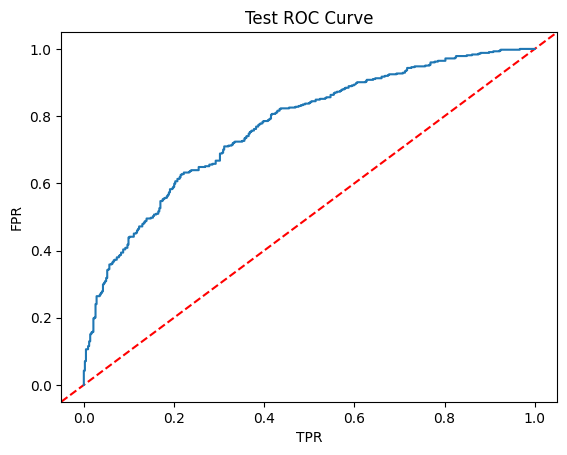

In [26]:
fig,ax = plt.subplots()

ax.axline((0,0),slope=1,color='red',linestyle='--')
ax.plot(fpr,tpr)
ax.set_xlabel('TPR')
ax.set_ylabel('FPR')
ax.set_title('Test ROC Curve')

In [27]:
AUC = roc_auc_score(y_test_sm,y_test_pred)
Gini = 2*AUC-1
print('ROC AUC: ',AUC*100,'\nGini: ',Gini*100)

ROC AUC:  76.91210172659308 
Gini:  53.82420345318617


### OOT Data

In [28]:
y_pred_OOT = log_reg.predict(df_ML_OOT_sm)
y_OOT = df_ML_OOT_sm['Outcome']
fpr,tpr, thresholds = roc_curve(y_OOT,y_pred_OOT)

Text(0.5, 1.0, 'OOT ROC Curve')

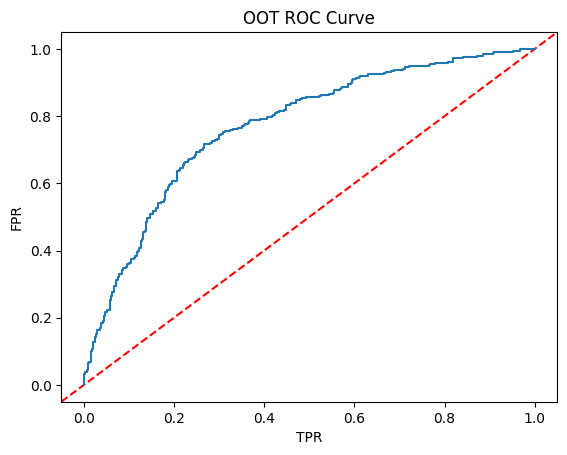

In [29]:
fig,ax = plt.subplots()

ax.axline((0,0),slope=1,color='red',linestyle='--')
ax.plot(fpr,tpr)
ax.set_xlabel('TPR')
ax.set_ylabel('FPR')
ax.set_title('OOT ROC Curve')

In [30]:
AUC = roc_auc_score(y_OOT,y_pred_OOT)
Gini = 2*AUC-1
print('ROC AUC: ',AUC*100,'\nGini: ',Gini*100)

ROC AUC:  77.01665629593558 
Gini:  54.03331259187114


In [31]:
#Check against original dataset
df_matches_v3['Predicted'] = log_reg.predict(df_matches_v3)

In [32]:
#Get the other side of the match
df_matches_v3 = df_matches_v3.merge(df_matches_v3[['Season','Round','Opponent','Predicted']],
                                    left_on=['Season','Round','Team'],right_on=['Season','Round','Opponent'],\
                                    suffixes=('_team','_opp')) 

df_matches_v3=df_matches_v3.rename(columns={'Opponent_team':'Opponent'})

In [33]:
df_matches_v3['Predicted_team2'] = 1 - df_matches_v3['Predicted_opp']
df_matches_v3['Predicted_final'] = (df_matches_v3['Predicted_team2'] + df_matches_v3['Predicted_team'] )/2
df_matches_v3[['Team','Opponent','Season','Outcome','Predicted_final']]

,Team,Opponent,Season,Outcome,Predicted_final
0,Adelaide,Hawthorn,2013,0,0.379273
1,Adelaide,Greater Western Sydney,2013,1,0.725327
2,Adelaide,St Kilda,2013,1,0.758864
3,Adelaide,North Melbourne,2013,1,0.493282
4,Adelaide,Fremantle,2013,0,0.450735
...,...,...,...,...,...
3487,Western Bulldogs,Greater Western Sydney,2023,0,0.659849
3488,Western Bulldogs,Richmond,2023,1,0.659823
3489,Western Bulldogs,Hawthorn,2023,0,0.645413
3490,Western Bulldogs,West Coast,2023,0,0.872911


In [34]:
acc_agg = df_matches_v3[['Season','Team','Outcome','Predicted_final']].groupby(['Season','Team']).mean().reset_index()

In [35]:
team_list = list(df_matches_v3['Team'].unique())

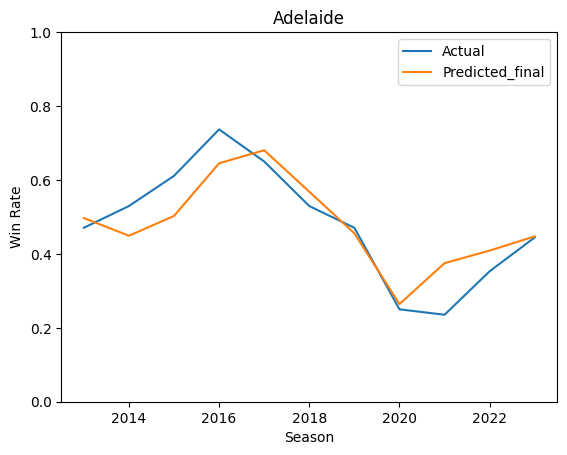

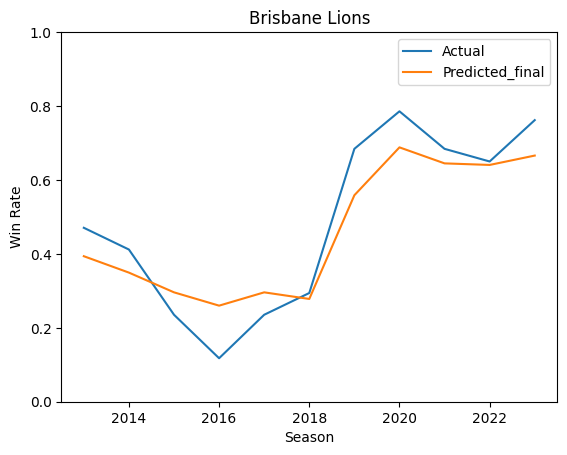

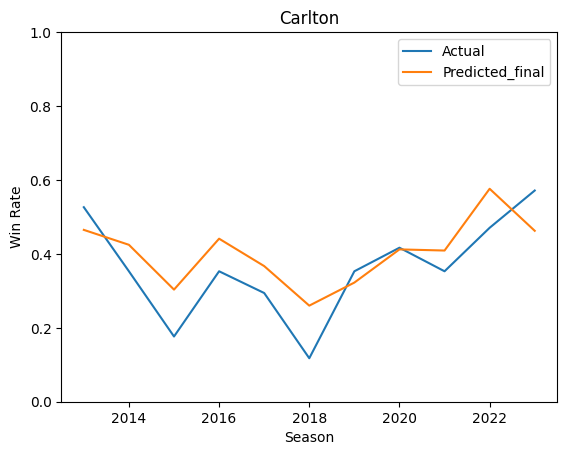

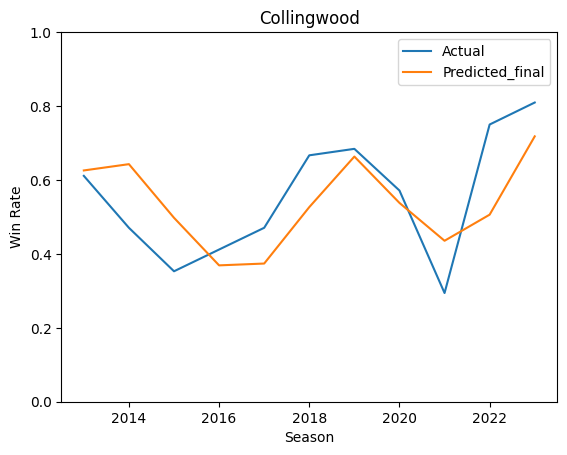

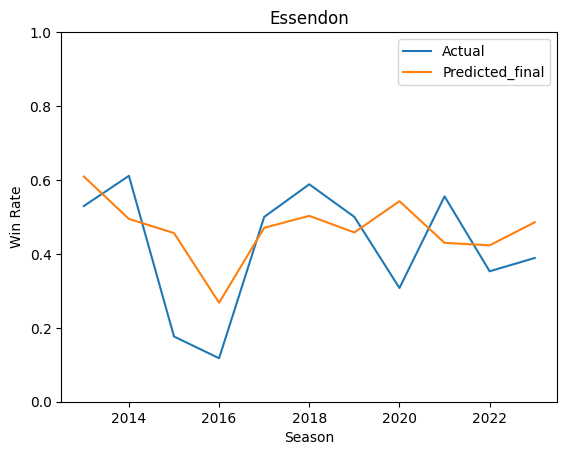

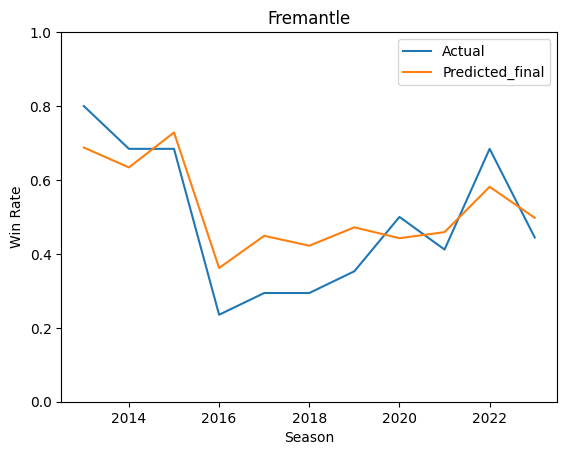

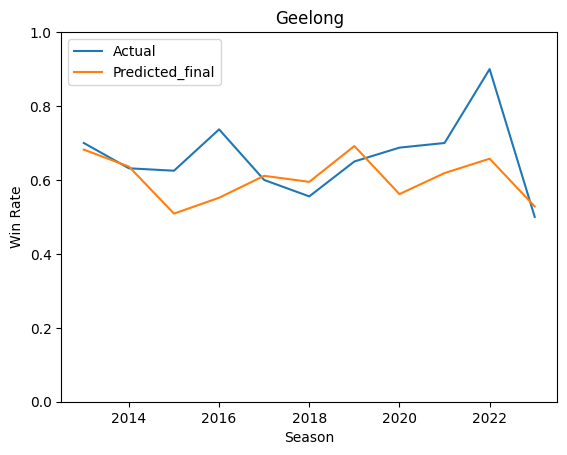

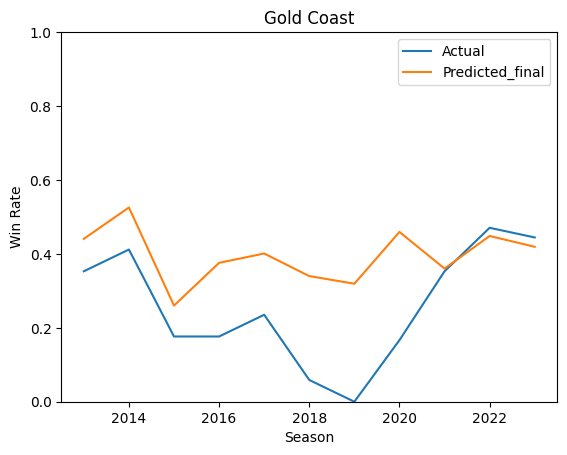

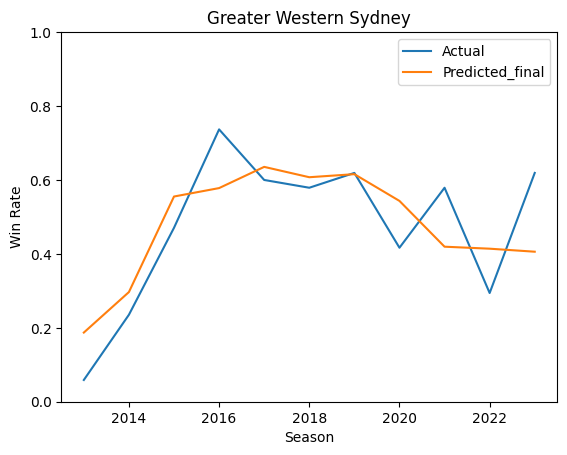

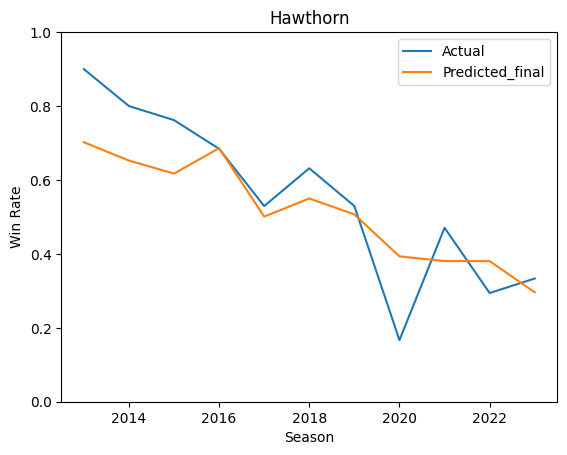

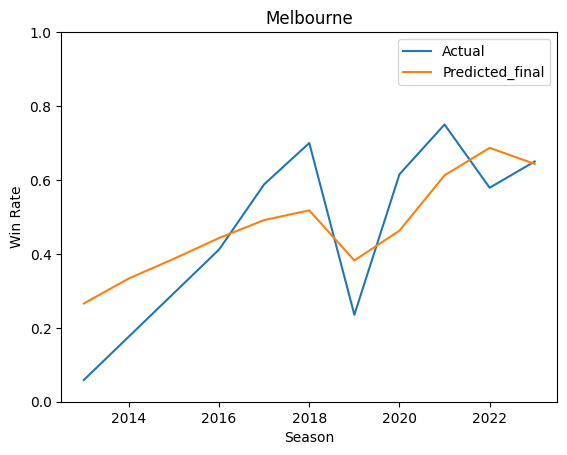

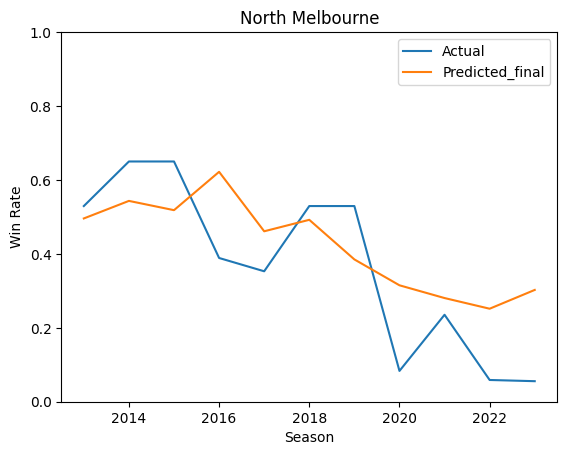

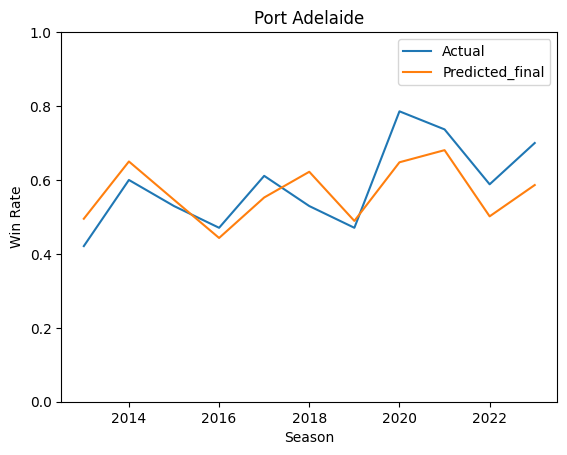

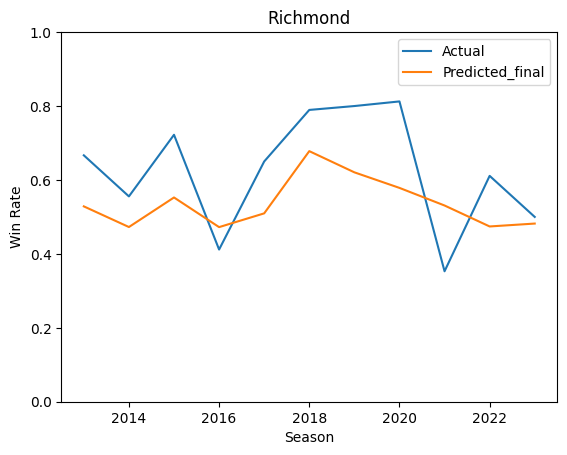

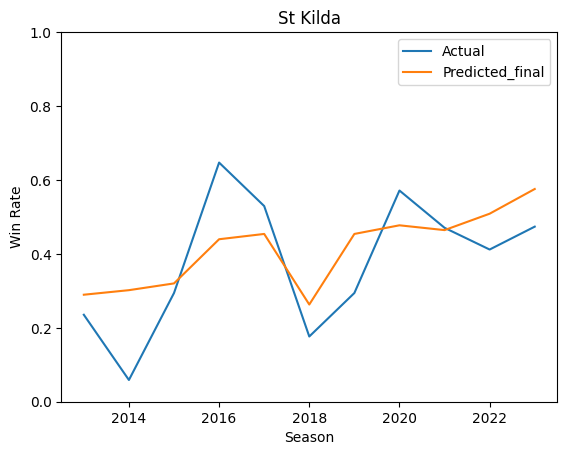

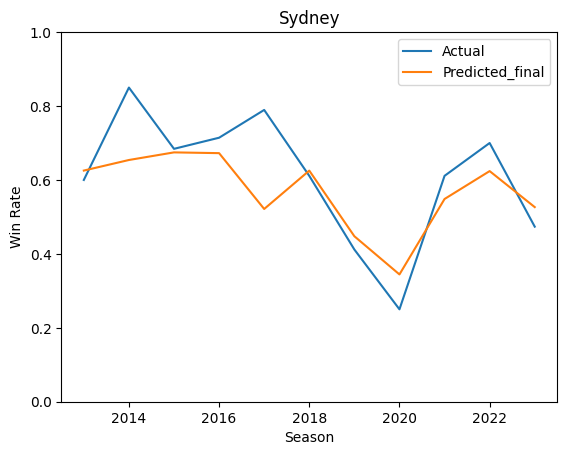

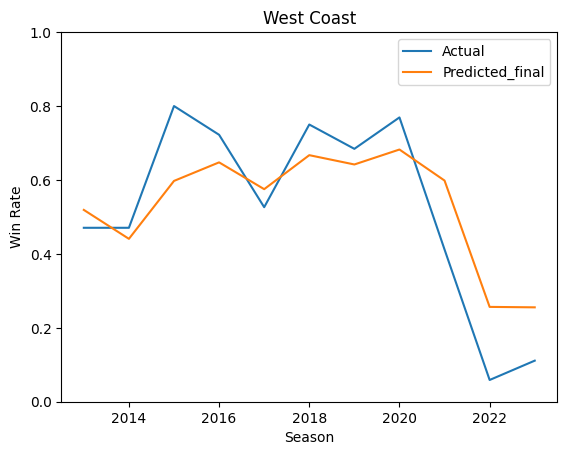

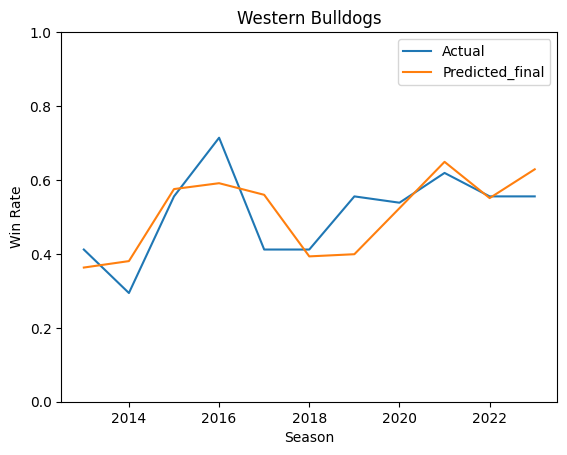

In [36]:
for team in team_list:
    team_ts = acc_agg[acc_agg['Team']==team]
    fig,ax = plt.subplots()
    
    ax.plot(team_ts['Season'],team_ts[['Outcome','Predicted_final']])
    ax.set_title(team)
    ax.set_xlabel('Season')
    ax.set_ylabel('Win Rate')
    ax.set_ylim(0,1)
    ax.legend(['Actual','Predicted_final'])
    

In [37]:
df_matches_v3[['Team','Outcome','Predicted_final']].groupby('Team').mean()

,Outcome,Predicted_final
Team,,
Adelaide,0.492063,0.491814
Brisbane Lions,0.492308,0.467386
Carlton,0.367021,0.405597
Collingwood,0.565657,0.540770
Essendon,0.425532,0.465731
Fremantle,0.500000,0.529865
Geelong,0.665049,0.607505
Gold Coast,0.262295,0.393799
Greater Western Sydney,0.487437,0.481786


In [38]:
df_matches_v3['Predicted_round'] = (df_matches_v3['Predicted_final'] >= 0.5).astype(int) 

In [39]:
from sklearn.metrics import accuracy_score,precision_score

acc = accuracy_score(df_matches_v3['Outcome'],df_matches_v3['Predicted_round'])
prec = precision_score(df_matches_v3['Outcome'],df_matches_v3['Predicted_round'])
print('Whole Time Range:\n-------------\n','\nAccuracy: ',round(acc*100,2),'%','\nPrecision: ',round(prec*100,2),'%\n')

df_OOT_temp = df_matches_v3[df_matches_v3['Season']>=2022]
acc = accuracy_score(df_OOT_temp['Outcome'],df_OOT_temp['Predicted_round'])
prec = precision_score(df_OOT_temp['Outcome'],df_OOT_temp['Predicted_round'])
print('OOT Range:\n-------------\n','\nAccuracy: ',round(acc*100,2),'%','\nPrecision: ',round(prec*100,2),'%\n')

Whole Time Range:
-------------
 
Accuracy:  67.98 % 
Precision:  67.98 %

OOT Range:
-------------
 
Accuracy:  72.67 % 
Precision:  72.67 %



### NOTES

- Training Gini is somewhat lower than ideal.
- Accuracy is not amazing at 68%, however compares well to other models attaining accuracy in the 65-72% range.

# Random Forest

## Recursive Feature Elimination

In [57]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

#Get Team and Opponent features
team_opp_cols = X_train.filter(regex=('(Team_*.|Opponent_.*)')).columns.to_list()

selector = RFE(RandomForestClassifier(random_state=5432,n_jobs=-1),n_features_to_select=15,step=1)
selector.fit(X_train.drop(team_opp_cols,axis=1),y_train)

RFE(estimator=RandomForestClassifier(n_jobs=-1, random_state=5432),
    n_features_to_select=15)

In [76]:
rf_features = X_train.drop(team_opp_cols,axis=1).iloc[:,selector.support_].columns.to_list()

In [77]:
rf_model = RandomForestClassifier(random_state=5432,n_jobs=-1)

rf_model.fit(X_train[rf_features],y_train)
#rf_model.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1, random_state=5432)

In [78]:
importances = rf_model.feature_importances_
forest_importances = pd.Series(importances,index=rf_features).sort_values()

<Axes: >

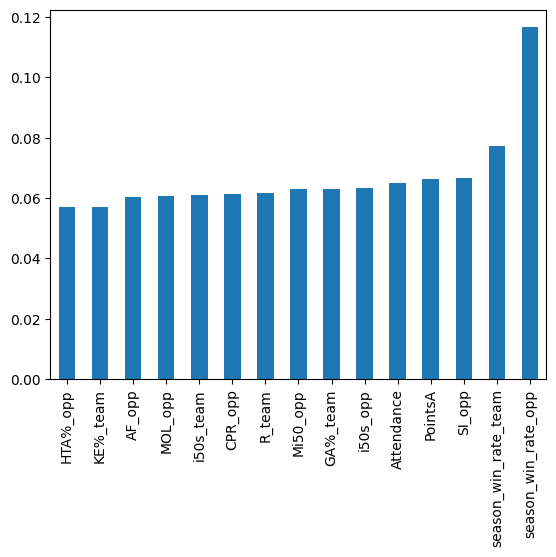

In [79]:
forest_importances.plot.bar()

In [80]:
y_pred_test = rf_model.predict(X_test[rf_features])
acc = accuracy_score(y_test,y_pred_test)
print('Test Data:\n-------------\n','\nAccuracy: ',round(acc*100,2),'%','\nPrecision: ',round(prec*100,2),'%\n')

Test Data:
-------------
 
Accuracy:  61.86 % 
Precision:  69.67 %



In [81]:
y_pred_OOT = rf_model.predict(df_ML_OOT[rf_features])
y_OOT = df_ML_OOT['Outcome']
acc = accuracy_score(y_OOT,y_pred_OOT)
print('OOT Range:\n-------------\n','\nAccuracy: ',round(acc*100,2),'%','\nPrecision: ',round(prec*100,2),'%\n')

OOT Range:
-------------
 
Accuracy:  64.41 % 
Precision:  69.67 %



In [82]:
df_compare = pd.DataFrame({'LogReg':df_OOT_temp['Predicted_round'],'RF':y_pred_OOT})
pd.crosstab(df_compare['LogReg'],df_compare['RF'])

RF,0,1
LogReg,,
0,234,99
1,50,283


### Notes

Random Forest has lower performance than logistic regression. However may prove useful in ensemble voting.

# SVM 

In [83]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

log_reg_feats = ['win_streak_team','win_streak_opp','PointsA','i50s_team','G_opp','season_win_rate_team','season_win_rate_opp','HA_H','oppHA_H']

svc_model = make_pipeline(StandardScaler(),SVC(kernel='linear'))
svc_model.fit(X_train[log_reg_feats],y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear'))])

In [84]:
y_pred_test = svc_model.predict(X_test[log_reg_feats])
acc = accuracy_score(y_test,y_pred_test)
print('Test Data:\n-------------\n','\nAccuracy: ',round(acc*100,2),'%','\nPrecision: ',round(prec*100,2),'%\n')

Test Data:
-------------
 
Accuracy:  66.29 % 
Precision:  69.67 %



In [85]:
y_pred_OOT = svc_model.predict(df_ML_OOT[log_reg_feats])
y_OOT = df_ML_OOT['Outcome']
acc = accuracy_score(y_OOT,y_pred_OOT)
print('OOT Range:\n-------------\n','\nAccuracy: ',round(acc*100,2),'%','\nPrecision: ',round(prec*100,2),'%\n')

OOT Range:
-------------
 
Accuracy:  68.62 % 
Precision:  69.67 %



### Note

SVM shows similar performance to logistic regression. However, not useful in ensemble voting since it's picking up the same wins in most cases.

In [86]:
df_compare = pd.DataFrame({'LogReg':df_OOT_temp['Predicted_round'],'SVM':y_pred_OOT})

In [87]:
pd.crosstab(df_compare['LogReg'],df_compare['SVM'])

SVM,0,1
LogReg,,
0,292,41
1,24,309


# XGBOOST

In [90]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [100]:
param_grid = {
    'learning_rate':[0.3,0.25,0.20,0.15,0.1,0.05,0.01,0.001],
    'max_depth': [3,5,7,10,20],
    'subsample': [0.5,0.7,1]
}

xgb_model = xgb.XGBClassifier(device="cuda")

grid_search = GridSearchCV(xgb_model,param_grid,cv=5,scoring='accuracy')
grid_search.fit(X_train.drop(['win_streak_team_binned_a. [0,2]','win_streak_team_binned_b. (2,Inf)',
                            'win_streak_opp_binned_a. [0,2]','win_streak_opp_binned_b. (2,Inf)'],axis=1),y_train)

print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1}
Best score:  0.6653504243071627


In [102]:
xgb_model = xgb.XGBClassifier(learning_rate=0.1,max_depth=3,subsample=1,random_state=5432)
xgb_model.fit(X_train.drop(['win_streak_team_binned_a. [0,2]','win_streak_team_binned_b. (2,Inf)',
                            'win_streak_opp_binned_a. [0,2]','win_streak_opp_binned_b. (2,Inf)'],axis=1),y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=5432, ...)

In [104]:
y_pred_test = xgb_model.predict(X_test.drop(['win_streak_team_binned_a. [0,2]','win_streak_team_binned_b. (2,Inf)',
                            'win_streak_opp_binned_a. [0,2]','win_streak_opp_binned_b. (2,Inf)'],axis=1))
acc = accuracy_score(y_test,y_pred_test)
print('Test Data:\n-------------\n','\nAccuracy: ',round(acc*100,2),'%','\nPrecision: ',round(prec*100,2),'%\n')

Test Data:
-------------
 
Accuracy:  65.04 % 
Precision:  69.67 %



In [107]:
y_pred_OOT = xgb_model.predict(df_ML_OOT.drop(['win_streak_team_binned_a. [0,2]','win_streak_team_binned_b. (2,Inf)',
                            'win_streak_opp_binned_a. [0,2]','win_streak_opp_binned_b. (2,Inf)','Outcome','Season'],axis=1))
y_OOT = df_ML_OOT['Outcome']
acc = accuracy_score(y_OOT,y_pred_OOT)
print('OOT Range:\n-------------\n','\nAccuracy: ',round(acc*100,2),'%','\nPrecision: ',round(prec*100,2),'%\n')

OOT Range:
-------------
 
Accuracy:  68.47 % 
Precision:  69.67 %



In [108]:
df_compare = pd.DataFrame({'LogReg':df_OOT_temp['Predicted_round'],'XGB':y_pred_OOT})
pd.crosstab(df_compare['LogReg'],df_compare['XGB'])

XGB,0,1
LogReg,,
0,231,102
1,28,305


## NOTES

Useful in a voting ensemble. Try the following:
- Feature Selection for XGB.
- Further Fine Tuning.
- Try PCA for feature reduction in XGBoost and Random Forest.
- Try standardising numerical variables for tree based methods.